In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from benchmark_mae.evaluate import edge_roc_curve
from rhapsody.util import rank_hits
from itertools import product
from skbio.stats.composition import clr, centralize
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from benchmark_mae.generators import ground_truth_edges
from benchmark_mae.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
import yaml
%matplotlib inline

ModuleNotFoundError: No module named 'benchmark_mae'

In [24]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])

iteration = '0_a'

In [3]:
results_dir = '../../results/depth_benchmark/'
with open('%s/depth_params11.yaml' % results_dir, 'r') as f:
    effect_params = yaml.load(f)

sample_ids = effect_params['samples']
modes = effect_params['modes']
tools = ['deep_mae', 'pearson', 'spearman']

In [4]:
ids = list(product(tools, modes, sample_ids))
fnames = list(map(lambda x: '.'.join(x) + '.results', ids))

In [5]:
df = pd.DataFrame(ids, index=fnames, columns=['tools', 'modes', 'samples'])

In [6]:
kmax = [1, 10, 20, 25, 50, 75, 100]

Deep learning ranks

In [7]:
sample = sample_ids[0] 
tool = tools[0]
r_fname = 'deep_mae.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [8]:
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [9]:
metabolites = load_table(
    os.path.join(results_dir, 'table.rel.metabolites.1_a.biom')
).to_dataframe().T

microbes = load_table(
    os.path.join(results_dir, 'table.rel.microbes.1_a.biom')
).to_dataframe().T

edges = ground_truth_edges(microbes, metabolites)

In [10]:
mae_pos, mae_neg = _edge_roc_curve(rel_ranks, edges, axis=1, ks=kmax)

In [25]:
mae_pos['TPR'] = mae_pos.apply(sensitivity, axis=1)
mae_pos['TNR'] = mae_pos.apply(specificity, axis=1)
mae_pos['precision'] = mae_pos.apply(precision, axis=1)
mae_pos['recall'] = mae_pos.apply(recall, axis=1)

Spearman

In [12]:
sample = sample_ids[0] 
tool = tools[0]
r_fname = 'spearman.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [13]:
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [14]:
spear_pos, spear_neg = _edge_roc_curve(rel_ranks, edges, ks=kmax)

In [26]:
spear_pos['TPR'] = spear_pos.apply(sensitivity, axis=1)
spear_pos['TNR'] = spear_pos.apply(specificity, axis=1)
spear_pos['precision'] = spear_pos.apply(precision, axis=1)
spear_pos['recall'] = spear_pos.apply(recall, axis=1)

Pearson

In [16]:
sample = sample_ids[0] 
tool = tools[0]
r_fname = 'pearson.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [17]:
rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [18]:
pear_pos, pear_neg = _edge_roc_curve(rel_ranks, edges, ks=kmax)

In [27]:
pear_pos['TPR'] = pear_pos.apply(sensitivity, axis=1)
pear_pos['TNR'] = pear_pos.apply(specificity, axis=1)
pear_pos['precision'] = pear_pos.apply(precision, axis=1)
pear_pos['recall'] = pear_pos.apply(recall, axis=1)

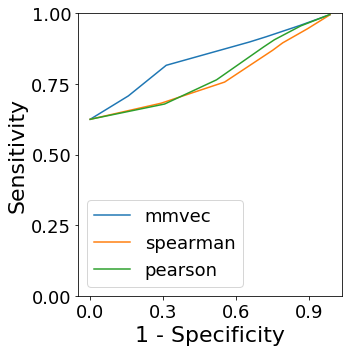

In [28]:
fontsize = 22
labelsize = 18

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(1-mae_pos['TPR'], mae_pos['TNR'], label='mmvec')
ax.plot(1-spear_pos['TPR'], spear_pos['TNR'], label='spearman')
ax.plot(1-pear_pos['TPR'], pear_pos['TNR'], label='pearson')
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.legend(prop={'size': 18})
ax.set_xlabel('1 - Specificity', fontsize=fontsize) 
ax.set_ylabel('Sensitivity', fontsize=fontsize)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.set_ylim([0, 1])
plt.tight_layout()
fig.savefig('../../figures/figure3/depth_roc.png')
fig.savefig('../../figures/figure3/depth_roc.pdf')

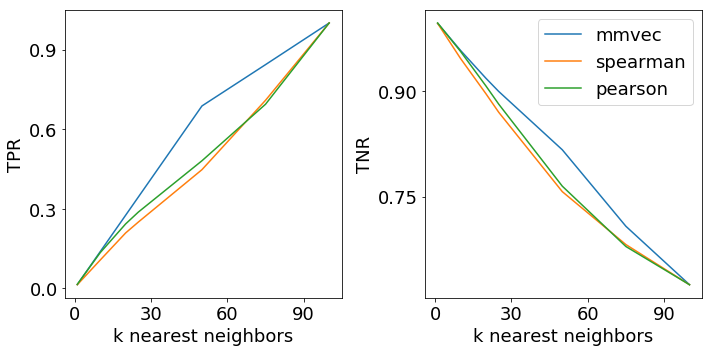

In [29]:
labelsize=18
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(mae_pos['TPR'].index, mae_pos['TPR'].values, label='mmvec')
ax[0].plot(spear_pos['TPR'].index, spear_pos['TPR'].values, label='spearman')
ax[0].plot(pear_pos['TPR'].index, pear_pos['TPR'].values, label='pearson')
ax[0].set_xlabel('k nearest neighbors', fontsize=labelsize)
ax[0].set_ylabel('TPR', fontsize=labelsize)
ax[0].xaxis.set_major_locator(MaxNLocator(4))
ax[0].yaxis.set_major_locator(MaxNLocator(4)) 
ax[0].xaxis.set_tick_params(labelsize=labelsize)
ax[0].yaxis.set_tick_params(labelsize=labelsize)

ax[1].plot(mae_pos['TNR'].index, mae_pos['TNR'].values, label='mmvec')
ax[1].plot(spear_pos['TNR'].index, spear_pos['TNR'].values, label='spearman')
ax[1].plot(pear_pos['TNR'].index, pear_pos['TNR'].values, label='pearson')
ax[1].legend(fontsize=labelsize)
ax[1].set_xlabel('k nearest neighbors', fontsize=labelsize)
ax[1].set_ylabel('TNR', fontsize=labelsize)
ax[1].xaxis.set_major_locator(MaxNLocator(4))
ax[1].yaxis.set_major_locator(MaxNLocator(4)) 
ax[1].xaxis.set_tick_params(labelsize=labelsize)
ax[1].yaxis.set_tick_params(labelsize=labelsize)

plt.tight_layout()

In [31]:
mae_pos['f1'] = 2 * mae_pos['precision'] * mae_pos['recall'] / (mae_pos['precision'] + mae_pos['recall'])
spear_pos['f1'] = 2 * spear_pos['precision'] * spear_pos['recall'] / (spear_pos['precision'] + spear_pos['recall'])
pear_pos['f1'] = 2 * pear_pos['precision'] * pear_pos['recall'] / (pear_pos['precision'] + pear_pos['recall'])

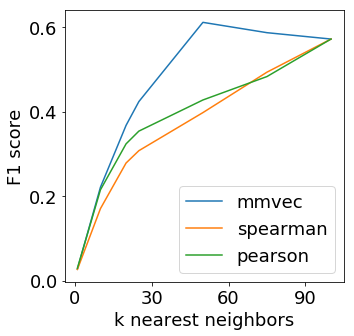

In [37]:
labelsize=18
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(mae_pos['f1'].index, mae_pos['f1'].values, label='mmvec')
ax.plot(spear_pos['f1'].index, spear_pos['f1'].values, label='spearman')
ax.plot(pear_pos['f1'].index, pear_pos['f1'].values, label='pearson')
ax.set_xlabel('k nearest neighbors', fontsize=labelsize)
ax.set_ylabel('F1 score', fontsize=labelsize)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4)) 
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.legend(fontsize=18)